In [289]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pygeohydro import WBD
from pynhd import NHD
from shapely.geometry import box, LineString, MultiPoint
from shapely.ops import split
from shapely.ops import snap

In [390]:
def random_cmap(length=10):
    vals = np.linspace(0,1,length)
    np.random.shuffle(vals)
    cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
    return cmap

In [391]:
aoi = box(-122.4484, 37.0866, -122.0419, 37.55)

In [392]:
fields = [
    'COMID',
    'LENGTHKM',
]

nhd = NHD('flowline_mr', outfields = fields)
flowlines = nhd.bygeom(aoi, geo_crs=4326)
flowlines = flowlines.to_crs(3310)
flowlines['length'] = flowlines['geometry'].apply(lambda x: x.length)
flowlines

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,geometry,COMID,LENGTHKM,length
0,"LINESTRING (-187802.766 -60474.326, -187669.89...",17692863,2.191,2189.726604
1,"LINESTRING (-193747.590 -64749.725, -193736.92...",17693217,11.176,11179.855505
2,"LINESTRING (-193905.314 -65219.662, -193875.25...",17692959,0.543,540.321451
3,"LINESTRING (-193804.588 -68078.053, -193791.44...",17692977,3.147,3129.201278
4,"LINESTRING (-194675.807 -69812.392, -194669.58...",17693239,2.072,2063.385571
...,...,...,...,...
807,"LINESTRING (-182221.806 -95365.803, -182227.21...",17682310,1.507,1498.328735
808,"LINESTRING (-184247.804 -95529.018, -184126.46...",17682312,2.044,2044.931770
809,"LINESTRING (-182427.719 -96738.283, -182425.12...",17682708,0.583,583.801608
810,"LINESTRING (-183043.242 -96803.381, -183028.78...",17682710,0.333,331.850351


<Axes: >

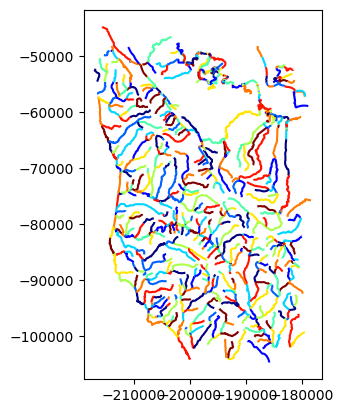

In [393]:
flowlines.plot(cmap=random_cmap())

In [387]:
def segment(line, length=500, method="remainder"):
    # https://gis.stackexchange.com/questions/386482/splitting-line-geodataframe-basing-on-given-lengths/386527#386527
    # https://github.com/shapely/shapely/issues/1058#issuecomment-755016543
    
    if method not in ['remainder', 'equal']:
        raise ValueError(f"method must be 'remainder' or 'equal' when {method} was provided")
    
    if method == "remainder":
        distances = np.arange(0, line.length, length)
    elif method == "equal":
        nparts = line.length // length
        if nparts == 0:
            distances = np.arange(0, line.length, line.length)
        else:        
            distances = np.arange(0, line.length, line.length/nparts)
        
    points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
    points = shapely.unary_union(points)
    snapped = snap(line, points, tolerance=0.01) 
    return list(split(snapped, points).geoms)

In [388]:
segments = flowlines.copy()
segments['split'] = segments['geometry'].apply(segment, length=200, method='remainder')
segments = segments.explode('split')
segments['geometry'] = segments['split']
segments = segments[['geometry', 'COMID', 'LENGTHKM', 'length']]
segments['new_length'] = segments['geometry'].apply(lambda x: x.length)
segments

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_d

,geometry,COMID,LENGTHKM,length,new_length
0,"LINESTRING (-187802.766 -60474.326, -187669.89...",17692863,2.191,2189.726604,200.000000
0,"LINESTRING (-187620.890 -60545.383, -187598.83...",17692863,2.191,2189.726604,200.000000
0,"LINESTRING (-187446.052 -60463.626, -187433.37...",17692863,2.191,2189.726604,200.000000
0,"LINESTRING (-187487.152 -60275.886, -187498.36...",17692863,2.191,2189.726604,200.000000
0,"LINESTRING (-187506.599 -60080.156, -187503.98...",17692863,2.191,2189.726604,200.000000
...,...,...,...,...,...
811,"LINESTRING (-183409.144 -98866.802, -183445.27...",17682712,3.008,2994.908211,200.000000
811,"LINESTRING (-183539.900 -99010.873, -183591.59...",17682712,3.008,2994.908211,200.000000
811,"LINESTRING (-183719.836 -99093.305, -183752.03...",17682712,3.008,2994.908211,200.000000
811,"LINESTRING (-183800.360 -99256.254, -183798.25...",17682712,3.008,2994.908211,200.000000


<Axes: >

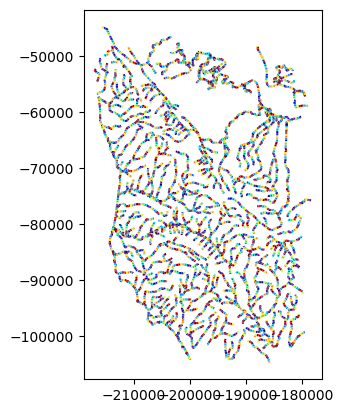

In [394]:
segments['geometry'].plot(cmap=random_cmap())